In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
sys.path.append("../tools/")
sys.path.append("../impl/")

import matplotlib.pyplot as plt
#import seaborn as sns

% matplotlib inline

In [2]:
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data, test_classifier
from preprocess import preprocess_df, preprocess, clean, ordered_columns

Get and clean data

In [7]:
with open("../impl/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient="index")
fixed_df = clean(df)
original_features = fixed_df.columns
fixed_df = preprocess_df(df)

my_dataset = preprocess(data_dict)

In [4]:
fixed_df.shape

(143, 36)

Oridinal features

In [5]:
print "Original number of features (columns) ", fixed_df[original_features].shape[1]
print "******************"
fixed_df[original_features].info()

Original number of features (columns)  20
******************
<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       94 non-null float64
to_messages                  86 non-null float64
deferral_payments            38 non-null float64
total_payments               123 non-null float64
exercised_stock_options      101 non-null float64
bonus                        81 non-null float64
restricted_stock             109 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    17 non-null float64
total_stock_value            125 non-null float64
expenses                     94 non-null float64
from_messages                86 non-null float64
other                        91 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          143 non-null bool
director_fees                16 non-null float64
deferred_income              48 n

Here we will introduce a few new features which possibly are more informative for analysis:

First we will scale number of emails from and to POI to the overall number of received and sent emails by a person.
We will add new feature - gross payments which also include deferred_income. Using this new feature we will calculate percentages for all constitutions of total payments. For example, salary_perc shows what percent in gross total payments goes as salary. In the same way we will calculate percentages of gross stock value constitutions.

In [6]:
new_columns = [col for col in fixed_df.columns if col not in original_features]
print "Added {} new columns".format(len(new_columns))
print "***********************"
fixed_df[new_columns].info()

Added 16 new columns
***********************
<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 16 columns):
from_poi_to_this_person_perc      86 non-null float64
from_this_person_to_poi_perc      86 non-null float64
shared_receipt_with_poi_perc      86 non-null float64
gross_payments                    46 non-null float64
gross_stock_value                 14 non-null float64
salary_perc                       36 non-null float64
bonus_perc                        33 non-null float64
long_term_incentive_perc          23 non-null float64
deferred_income_perc              46 non-null float64
deferral_payments_perc            16 non-null float64
other_perc                        36 non-null float64
expenses_perc                     37 non-null float64
director_fees_perc                10 non-null float64
exercised_stock_options_perc      11 non-null float64
restricted_stock_perc             13 non-null float64
restricted_stock_deferred

Define set of feature and prepare data in X, y format 

In [64]:
exclude = ["poi", "email_address"]
all_features_list = [f for f in my_dataset.items()[0][1].keys() if f not in exclude]

features_list_org = ['poi'] + ordered_columns + ["to_messages", "from_messages", "from_this_person_to_poi", 
                                                "shared_receipt_with_poi", "from_poi_to_this_person"]
features_list_ext = features_list_org + ["to_poi_perc", "from_poi_perc", "shared_with_poi_perc"]
features_list_full = ["poi"] + all_features_list

In [65]:
#features_list = ['poi'] + ordered_columns + ["to_messages", "from_messages"] + new_columns

data = featureFormat(my_dataset, features_list_org, sort_keys = True)
labels_org, features_org = targetFeatureSplit(data)

data = featureFormat(my_dataset, features_list_full, sort_keys = True)
labels_full, features_full = targetFeatureSplit(data)


## Feature selection

In [66]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler 

Perform ANOVA F-test

In [67]:
f, pval = f_classif(features_org, labels_org)

In [68]:
feat_fscore = sorted(zip(features_list_org[1:], f, pval), key = lambda s: s[1], reverse=True )
feat_fscore

[('exercised_stock_options', 24.815079733218194, 1.8182048777865317e-06),
 ('total_stock_value', 24.182898678566879, 2.4043152760436886e-06),
 ('bonus', 20.792252047181535, 1.10129873239521e-05),
 ('salary', 18.289684043404513, 3.4782737683651706e-05),
 ('deferred_income', 11.458476579280369, 0.00092203670846723062),
 ('long_term_incentive', 9.9221860131898225, 0.0019941812453537077),
 ('restricted_stock', 9.2128106219771002, 0.002862802957909168),
 ('total_payments', 8.7727777300916756, 0.0035893261725153044),
 ('shared_receipt_with_poi', 8.589420731682381, 0.0039458026165322567),
 ('other', 7.1501974379898821, 0.0083808944609322627),
 ('expenses', 6.0941733106389453, 0.014758199965371975),
 ('from_poi_to_this_person', 5.2434497133749582, 0.023513867086669714),
 ('from_this_person_to_poi', 2.3826121082276739, 0.12493365956927895),
 ('director_fees', 2.1263278020077054, 0.14701111317392224),
 ('to_messages', 1.6463411294420076, 0.20156265029435688),
 ('deferral_payments', 0.22461127473

Explore mutual information

In [69]:
from sklearn.feature_selection import mutual_info_classif

In [70]:
minf = mutual_info_classif(features_org, labels_org)
feat_infscore = sorted(zip(features_list_org[1:], minf), key = lambda s: s[1], reverse=True )
feat_infscore[:15]

[('bonus', 0.080299572748645742),
 ('shared_receipt_with_poi', 0.072626000733685414),
 ('expenses', 0.069549979272630402),
 ('other', 0.067042800255028734),
 ('total_stock_value', 0.042467659563932392),
 ('restricted_stock_deferred', 0.042079785052905772),
 ('restricted_stock', 0.039654110934802977),
 ('from_this_person_to_poi', 0.037321491423718545),
 ('salary', 0.034049148912266736),
 ('deferred_income', 0.023100839204649226),
 ('exercised_stock_options', 0.016627705046638575),
 ('total_payments', 0.010398512607012966),
 ('from_poi_to_this_person', 0.0048538823899357819),
 ('long_term_incentive', 0.0),
 ('deferral_payments', 0.0)]

In [71]:
top10_fscore = zip(*feat_fscore)[0][:10]
top10_fscore

('exercised_stock_options',
 'total_stock_value',
 'bonus',
 'salary',
 'deferred_income',
 'long_term_incentive',
 'restricted_stock',
 'total_payments',
 'shared_receipt_with_poi',
 'other')

In [72]:
top10_infscore = zip(*feat_infscore)[0][:10]
top10_infscore

('bonus',
 'shared_receipt_with_poi',
 'expenses',
 'other',
 'total_stock_value',
 'restricted_stock_deferred',
 'restricted_stock',
 'from_this_person_to_poi',
 'salary',
 'deferred_income')

F-statistics and mutual information give different rankings of feature influence, but features in the top are more or less the same.
Both methods state that the following features are most important (among top 10 important features for both methods):

In [73]:
set(top10_fscore).intersection(top10_infscore)

{'bonus',
 'deferred_income',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'total_stock_value'}

Now we will add new features and see how ranking change

In [74]:
f, pval = f_classif(features_full, labels_full)
feat_fscore_full = sorted(zip(features_list_full[1:], f, pval), key = lambda s: s[1], reverse=True )

minf = mutual_info_classif(features_full, labels_full)
feat_infscore_full = sorted(zip(features_list_full[1:], minf), key = lambda s: s[1], reverse=True )

In [75]:
top10_fscore_full = zip(*feat_fscore_full)[0][:10]
top10_infscore_full = zip(*feat_infscore_full)[0][:10]

In [76]:
set(top10_fscore_full).intersection(top10_infscore_full)

{'bonus',
 'from_this_person_to_poi_perc',
 'gross_payments',
 'total_stock_value'}

After peforming ranking on a whole data set we have got interesting results. 

There are already only 4 features which were ranked in top 10 by both methods. There are 2 new features among them: gross_payments, to_poi_perc 

In [77]:
set(zip(*feat_fscore_full)[0][:15]).intersection(zip(*feat_infscore_full)[0][:15])

{'bonus',
 'from_this_person_to_poi_perc',
 'gross_payments',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'total_stock_value'}

In [78]:
d = {}
for feat, f, pval in feat_fscore_full:
    d[feat] = f 

In [79]:
l = []
feat_dict = {}
for feat in features_list_org[1:]:
    new_feat = feat + "_perc"
    feat_dict[feat] = new_feat
    if new_feat in features_list_full:
        l.append([feat, d[feat], new_feat, d[new_feat] ])

        
        
for feat in ["total_payments", "total_stock_value"]:
    new_feat = feat.replace("total", "gross")
    feat_dict[feat] = new_feat
    l.append([feat, d[feat], new_feat, d[new_feat] ])
    


In [80]:

l_df = pd.DataFrame(l, columns = ["original", "fval", "new", "new_fval"])
l_df["diff"] = l_df["new_fval"] - l_df["fval"]
l_df["corr"] = l_df.original.map(lambda f: fixed_df[f].corr(fixed_df[feat_dict[f]]) )
l_df

,original,fval,new,new_fval,diff,corr
0,salary,18.289684,salary_perc,4.106780,-14.182904,-0.196172
1,bonus,20.792252,bonus_perc,19.709040,-1.083212,-0.044828
2,long_term_incentive,9.922186,long_term_incentive_perc,12.103787,2.181601,0.121355
3,deferred_income,11.458477,deferred_income_perc,1.487176,-9.971301,-0.337682
4,deferral_payments,0.224611,deferral_payments_perc,0.018443,-0.206169,0.324951
5,other,7.150197,other_perc,4.357890,-2.792307,0.502393
6,expenses,6.094173,expenses_perc,0.201163,-5.893011,0.703580
7,director_fees,2.126328,director_fees_perc,1.339722,-0.786606,0.607470
8,exercised_stock_options,24.815080,exercised_stock_options_perc,1.448859,-23.366220,0.369351
9,restricted_stock,9.212811,restricted_stock_perc,1.163234,-8.049577,0.028985


Next we can see examples where old and new feature are correlated

In [93]:
l_df[l_df["corr"].abs() > 0.5]

,original,fval,new,new_fval,diff,corr
5,other,7.150197,other_perc,4.357890,-2.792307,0.502393
6,expenses,6.094173,expenses_perc,0.201163,-5.893011,0.703580
7,director_fees,2.126328,director_fees_perc,1.339722,-0.786606,0.607470
14,total_payments,8.772778,gross_payments,11.334277,2.561500,0.992379
15,total_stock_value,24.182899,gross_stock_value,0.817445,-23.365454,0.987524


If we have to decide between two features, which one is better? Probably those, which have higher influence on the target variable. Next are features which are better to exclude

In [97]:
l_df[l_df["corr"].abs() > 0.5].apply(lambda r: r.original if r.fval<r.new_fval else r.new,  axis=1)

5             other_perc
6          expenses_perc
7     director_fees_perc
14        total_payments
15     gross_stock_value
dtype: object

One strategy can be to pick features manually using results from performed analysis

In [99]:
set(zip(*feat_fscore_full)[0][:20]).intersection(zip(*feat_infscore_full)[0][:20]) - {"total_payments", "other_perc"}

{'bonus',
 'deferred_income',
 'expenses',
 'from_poi_to_this_person_perc',
 'from_this_person_to_poi_perc',
 'gross_payments',
 'long_term_incentive',
 'long_term_incentive_perc',
 'other',
 'restricted_stock',
 'salary',
 'salary_perc',
 'shared_receipt_with_poi',
 'shared_receipt_with_poi_perc',
 'total_stock_value'}

TO DO: Make summary regarding introduced features

## PCA and Data Visualisation

In [82]:
exclude = ["poi", "email_address"]
all_features_list = [f for f in my_dataset.items()[0][1].keys() if f not in exclude]

features_list_org = ['poi'] + ordered_columns + ["to_messages", "from_messages"]
features_list_ext = features_list_org + ["to_poi_perc", "from_poi_perc", "shared_with_poi_perc"]
features_list_full = ["poi"] + all_features_list

In [83]:
from sklearn.decomposition import PCA

labels, features = targetFeatureSplit(featureFormat(my_dataset, features_list_org, sort_keys = True))
scaler = MinMaxScaler()
features_scl = scaler.fit_transform(features)
pca = PCA()
pca.fit(features_scl)

features_trf = pca.transform(features_scl)

In [84]:
pca.explained_variance_ratio_

array([  3.35310614e-01,   1.56179712e-01,   1.24116826e-01,
         1.02473738e-01,   7.94925675e-02,   4.76877910e-02,
         3.25273727e-02,   2.92559869e-02,   2.61835652e-02,
         2.05307273e-02,   1.78120379e-02,   1.61921381e-02,
         1.22104169e-02,   2.63638137e-05,   1.43632916e-07])

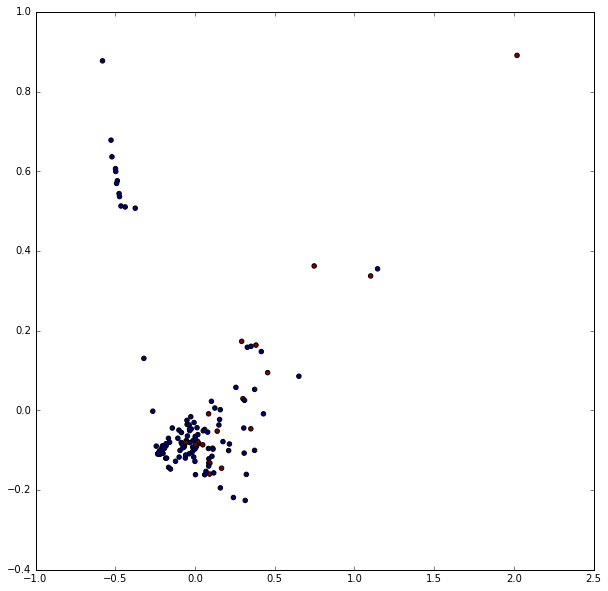

In [85]:
plt.subplots(figsize=(10,10))

plt.scatter(x=features_trf[:,0],y=features_trf[:,1],c=labels)

In [86]:
labels, features = targetFeatureSplit(featureFormat(my_dataset, features_list_ext, sort_keys = True))

features_scl = scaler.fit_transform(features)
pca = PCA()
pca.fit(features_scl)

features_trf = pca.transform(features_scl)

error: key  to_poi_perc  not present


TypeError: 'NoneType' object is not iterable

In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.subplots(figsize=(10,10))
plt.scatter(x=features_trf[:,0],y=features_trf[:,1],c=labels)